# 複数トライアル回した時の結果の評価

In [35]:
!pip install matplotlib-venn

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45288 sha256=5faddc1f4151385bc86e3045d84756b97a7d24db2bf4f7674ba8a8634046523d
  Stored in directory: /home/kodera/.cache/pip/wheels/96/4b/f9/2666d92914c7a707c7b84e40cf53a80b8eb1ae1b46fcc171f0
Successfully built matplotlib-venn


In [36]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
PROJECT_DIRPATH = Path('/tf/workspace/deformation-prediction-multi-environment')
NAS_DIRPATH = Path('/tf/nas/')

In [4]:
date = '2024-11-25'
time = '16-04-34'
results_filepath = NAS_DIRPATH/'experiments'/date/time/'results.csv'

results = pd.read_csv(results_filepath)

In [5]:
results

,Trial_id,Evaluation_id,Metric,Value
0,trial_0,0-0,loss,0.1981
1,trial_0,0-0,iou,0.3094
2,trial_0,0-0,mpa,0.6464
3,trial_0,0-1,loss,0.1587
4,trial_0,0-1,iou,0.3306
...,...,...,...,...
1255,trial_19,012-1,iou,0.3441
1256,trial_19,012-1,mpa,0.6625
1257,trial_19,012-2,loss,0.1901
1258,trial_19,012-2,iou,0.3653


# トライアル間の平均を算出

In [6]:
mean_values = results.pivot_table(
    index='Evaluation_id',
    columns='Metric',
    values='Value',
    aggfunc='mean'  # 平均を計算
).reset_index()
mean_values.columns.name = None

**`evaluation_id`の見方**  

例:
- `location_0`, `location_1`の訓練セットで訓練したモデルを`location_2`のテストセットで評価 -> `01-2`

In [7]:
mean_values

,Evaluation_id,iou,loss,mpa
0,0-0,0.327740,0.146190,0.658955
1,0-1,0.324905,0.141905,0.655170
2,0-2,0.272445,0.163200,0.624105
3,01-0,0.317030,0.169270,0.650625
4,01-1,0.322710,0.197975,0.650480
5,01-2,0.279270,0.178275,0.627430
6,012-0,0.347375,0.169690,0.672165
7,012-1,0.325450,0.237645,0.651700
8,012-2,0.334345,0.160395,0.665540
9,02-0,0.337190,0.164095,0.667660


In [52]:
def plot_venn_with_heatmap(values, title, set_labels=('A', 'B', 'C'), cmap_name='Reds'):
    """
    ヒートマップ風の色付けがされたベン図をプロットする関数。

    Parameters:
        values (dict): 部分集合をキー（'100', '010', '001', '110', '101', '011', '111'）、
                       値をその領域の値とする辞書。
        set_labels (tuple): 各集合のラベル名を指定するタプル（デフォルト: ('A', 'B', 'C')）。
        cmap_name (str): 使用するカラーマップの名前（デフォルト: 'Reds'）。
    """
    # カラーマップと正規化
    cmap = plt.cm.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=min(values.values()), vmax=max(values.values()))

    # ベン図を作成
    fig, ax = plt.subplots(figsize=(8, 8))
    venn = venn3(subsets=values, set_labels=set_labels)

    # 色付け
    for subset_id, value in values.items():
        patch = venn.get_patch_by_id(subset_id)
        if patch is not None:
            patch.set_color(cmap(norm(value)))
            patch.set_alpha(0.7)

    # ラベルを値に設定
    for subset_id, value in values.items():
        label = venn.get_label_by_id(subset_id)
        if label is not None:
            label.set_text(f"{value:.4f}")

    # カラーバーを追加
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # カラーバー用に空の配列をセット
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Value', rotation=270, labelpad=15)

    plt.title(title)
    plt.show()

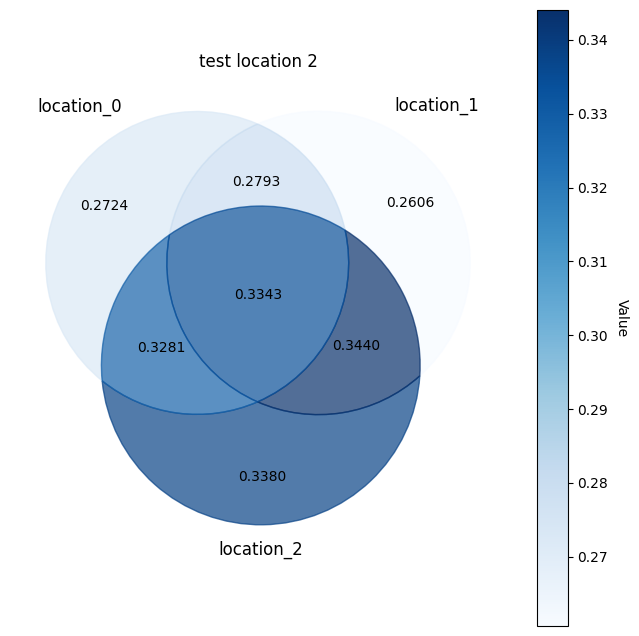

In [55]:
test_id = '2'
metric = 'iou'

# 各部分集合に対応する値
values = {
    '100': mean_values.loc[mean_values["Evaluation_id"] == f'0-{test_id}', metric].iloc[0],  # 0のみ
    '010': mean_values.loc[mean_values["Evaluation_id"] == f'1-{test_id}', metric].iloc[0],  # 1のみ
    '001': mean_values.loc[mean_values["Evaluation_id"] == f'2-{test_id}', metric].iloc[0],  # 2のみ
    '110': mean_values.loc[mean_values["Evaluation_id"] == f'01-{test_id}', metric].iloc[0],  # 01
    '101': mean_values.loc[mean_values["Evaluation_id"] == f'02-{test_id}', metric].iloc[0],  # 02
    '011': mean_values.loc[mean_values["Evaluation_id"] == f'12-{test_id}', metric].iloc[0],  # 12
    '111': mean_values.loc[mean_values["Evaluation_id"] == f'012-{test_id}', metric].iloc[0]  # 012
}


title = f'test location {test_id}'

# ベン図をプロット
plot_venn_with_heatmap(values, title, set_labels=('location_0', 'location_1', 'location_2'), cmap_name='Blues')

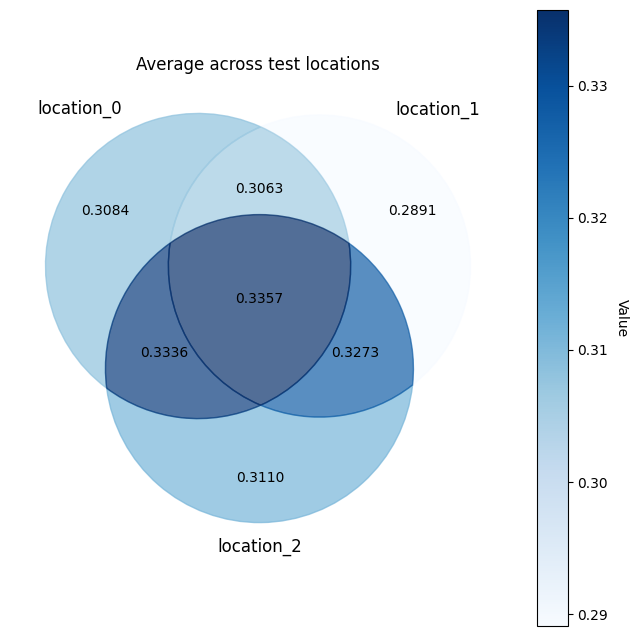

In [59]:
# test_id を 0~2 の範囲でループ
test_ids = range(3)
metric = 'iou'

# 空の辞書を用意して、各キーに対応する値を格納
values_accumulator = {
    '100': [],
    '010': [],
    '001': [],
    '110': [],
    '101': [],
    '011': [],
    '111': []
}

# 各 test_id の値を収集
for test_id in test_ids:
    for key, eval_id_suffix in {
        '100': f'0-{test_id}',
        '010': f'1-{test_id}',
        '001': f'2-{test_id}',
        '110': f'01-{test_id}',
        '101': f'02-{test_id}',
        '011': f'12-{test_id}',
        '111': f'012-{test_id}'
    }.items():
        # 該当する値を取得し、リストに追加
        value = mean_values.loc[mean_values["Evaluation_id"] == eval_id_suffix, metric]
        if not value.empty:  # 値が存在する場合のみ追加
            values_accumulator[key].append(value.iloc[0])

# 各キーごとに平均を計算
values = {key: np.mean(vals) for key, vals in values_accumulator.items()}

# プロット用のタイトル
title = 'Average across test locations'

# ベン図をプロット
plot_venn_with_heatmap(values, title, set_labels=('location_0', 'location_1', 'location_2'), cmap_name='Blues')

In [57]:
def plot_iou_heatmap_with_locations(df, train_locations, test_locations):
    """
    Plots an IoU heatmap for specified training and testing locations.

    Args:
        df (pd.DataFrame): DataFrame containing 'Evaluation_id' and 'iou' columns.
        train_locations (list): List of training location strings.
        test_locations (list): List of testing location strings.
    """
    # Create a DataFrame to store IoU values
    heatmap_data = pd.DataFrame(
        np.nan, index=train_locations, columns=test_locations, dtype=float
    )

    # Populate the heatmap data
    for _, row in df.iterrows():
        train_locs, test_loc = row['Evaluation_id'].split('-')
        if train_locs in train_locations and test_loc in test_locations:
            heatmap_data.loc[train_locs, test_loc] = row['iou']

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
    plt.title("IoU Heatmap")
    plt.xlabel("Test Locations")
    plt.ylabel("Train Locations")
    plt.show()

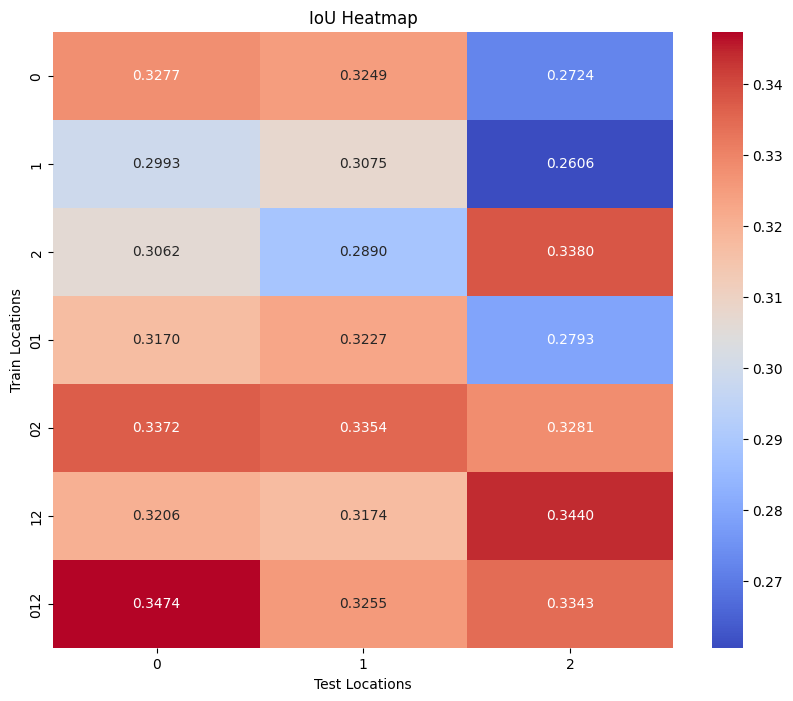

In [58]:
# Example usage
train_locations = ['0', '1', '2', '01', '02', '12', '012']
test_locations = ['0', '1', '2']
plot_iou_heatmap_with_locations(mean_values, train_locations, test_locations)

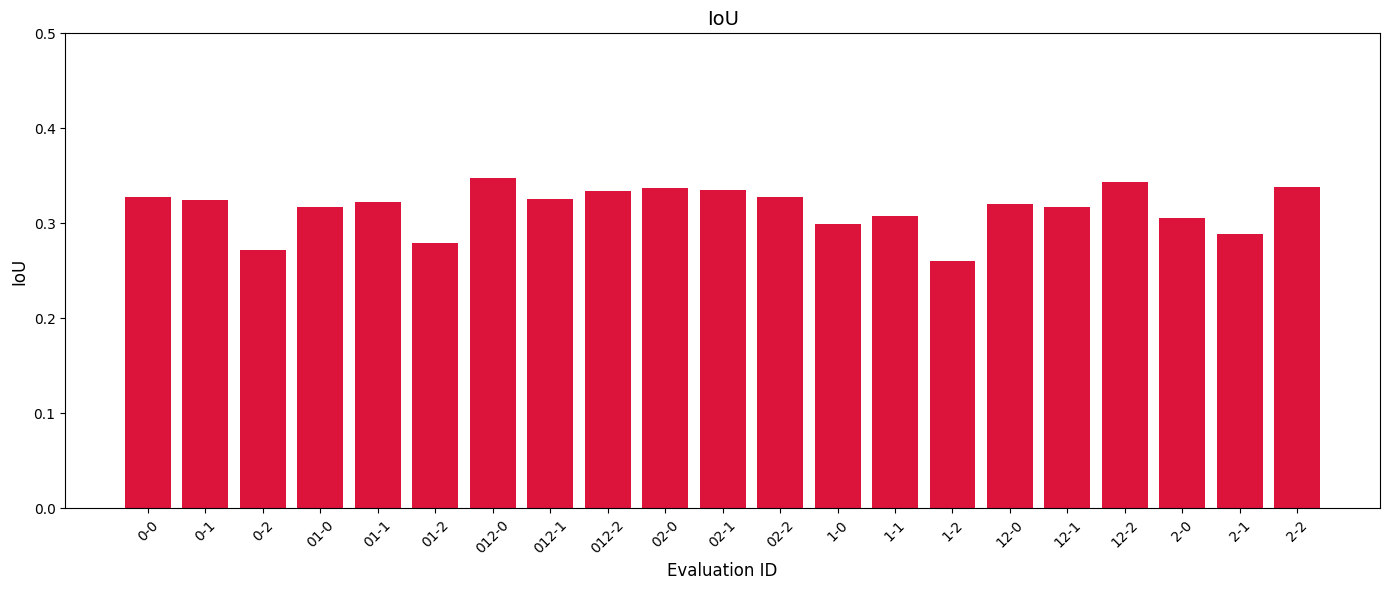

In [8]:
# グラフを描画
plt.figure(figsize=(14, 6))
plt.bar(mean_values["Evaluation_id"], mean_values["iou"], color="crimson")
plt.xlabel("Evaluation ID", fontsize=12)
plt.ylabel("IoU", fontsize=12)
plt.ylim([0, 0.5])
plt.title("IoU", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# グラフを表示
plt.show()